# **Overfitting**

In the last notebook, you have implemented a CNN model for the Fashion MNIST dataset, by adding more layers and parameters, you should see improvement in the training set accuracy. But can your model generalize well to the unseen data? Can you see a degrade in the test set accuracy when adding more parameters? This is a phenomenon called **overfitting**.

\
In this notebook, you will experiment with different regularization techniques (i.e. dropout and L1/L2 regularizations) to deal with overfitting.
You are going to compare the ***underfitted model***, ***overfitted model*** and the ***regularized model*** with the ***baseline model***.

\
**Instruction: type your code when you see 'Type your code here' in comments**

In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Tensorflow version:',tf.__version__)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
from sklearn.model_selection import train_test_split 
import os
print('Keras version:', tf.keras.__version__)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

Num GPUs Available:  1
Tensorflow version: 2.10.0
Keras version: 2.10.0


# Loading the Fashion MNIST dataset

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [15]:
print(f'Shape of an image: {x_train[0].shape}')
print(f'Max pixel value: {x_train.max()}')
print(f'Min pixel value: {x_train.min()}')
print(f'Classes: {np.unique(y_train)}')

Shape of an image: (28, 28)
Max pixel value: 255
Min pixel value: 0
Classes: [0 1 2 3 4 5 6 7 8 9]


In [16]:
# Creating a list of labels

fashion_mnist_labels = ["T-shirt/top", 
                            "Trouser",
                            "Pullover",
                            "Dress",
                            "Coat",
                            "Sandal", 
                            "Shirt",
                            "Sneaker",
                            "Bag",
                            "Ankle boot"]

# Plotting some of the images

Fontconfig warning: ignoring UTF-8: not a valid region tag


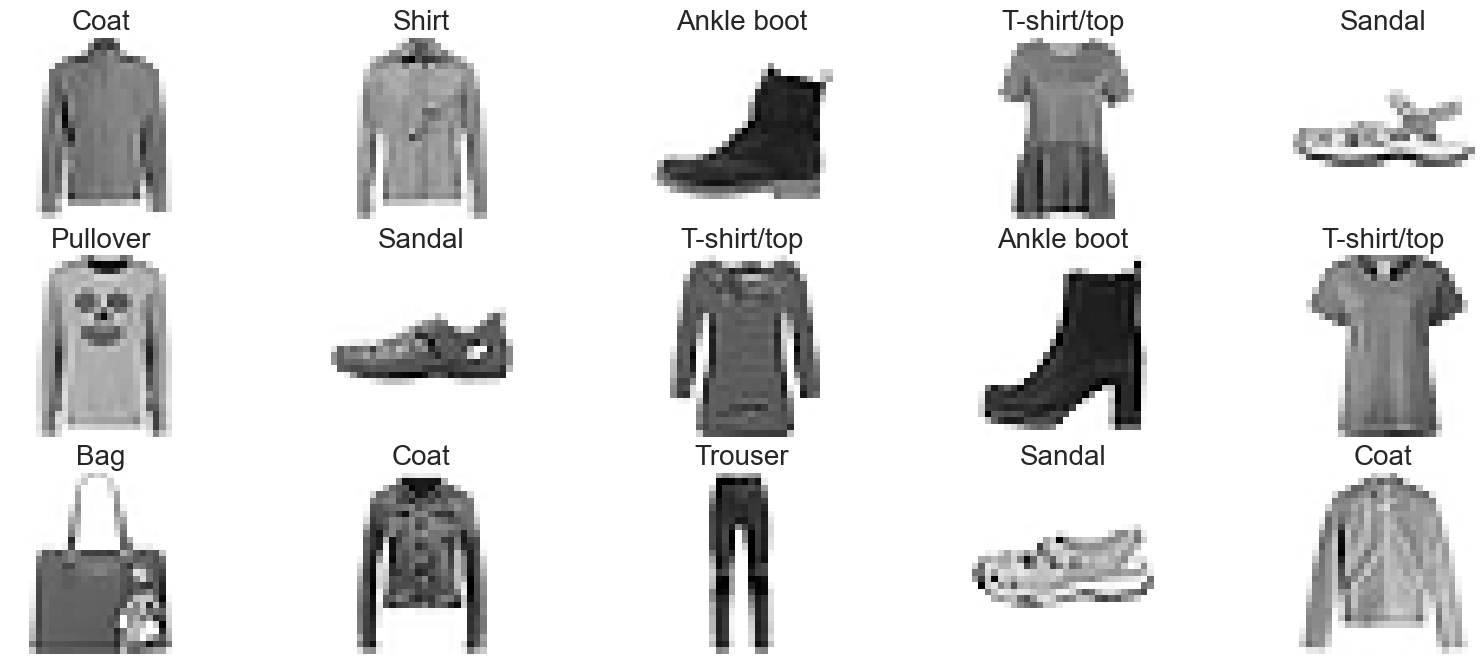

In [17]:
figure = plt.figure(figsize=(20,8))

indices = np.random.choice(np.arange(x_train.shape[0]), 15, replace=False)
subset = x_train[indices]

for i, image_sample in enumerate(subset):
  ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  j = fashion_mnist_labels[y_train[indices[i]]] #image label
  ax.set_title(j, fontsize=20)
  ax.imshow(image_sample.reshape(28,28))
  i+=1

In [18]:
x_train = x_train/255
x_test = x_test/255

num_classes = 10

train_one_hot = tf.keras.utils.to_categorical(y_train,num_classes)
test_one_hot = tf.keras.utils.to_categorical(y_test,num_classes)

print(y_train[0])
print(train_one_hot[0])

train_size = x_train.shape[0]
test_size = x_test.shape[0]


print(f'Max pixel value: {x_train.max()}')
print(f'Min pixel value: {x_train.min()}')
print(f'Train size: {train_size}, Test size: {test_size}')
print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')
print(f'Train label shape: {train_one_hot.shape}, Test label shape: {test_one_hot.shape}')


9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Max pixel value: 1.0
Min pixel value: 0.0
Train size: 60000, Test size: 10000
Train data shape: (60000, 28, 28), Test data shape: (10000, 28, 28)
Train label shape: (60000, 10), Test label shape: (10000, 10)


# **Model training**

In [19]:
batch_size = 100
epoch = 2000


es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=40,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)


## **Baseline model**

In [20]:
BASELINE_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+BASELINE_INPUT_SHAPE)
x_test = x_test.reshape([-1]+BASELINE_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [21]:
tf.keras.backend.clear_session()

inputs = Input(shape=BASELINE_INPUT_SHAPE)

x = Conv2D(filters=10, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(50, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

baseline_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="baseline_model")

baseline_model.summary()

Metal device set to: Apple M1 Pro


2022-10-29 17:37:13.586856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-29 17:37:13.587312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 10)        170       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 50)                98050     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                    

In [22]:
baseline_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


baseline_hist = baseline_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000


2022-10-29 17:37:21.491805: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-29 17:37:21.772857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


417/420 [============================>.] - ETA: 0s - loss: 0.5730 - accuracy: 0.7990

2022-10-29 17:37:29.455980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - 9s 15ms/step - loss: 0.5726 - accuracy: 0.7990 - val_loss: 0.4435 - val_accuracy: 0.8422
Epoch 2/2000
420/420 [==============================] - 6s 15ms/step - loss: 0.3951 - accuracy: 0.8626 - val_loss: 0.3763 - val_accuracy: 0.8657
Epoch 3/2000
420/420 [==============================] - 6s 14ms/step - loss: 0.3473 - accuracy: 0.8776 - val_loss: 0.3596 - val_accuracy: 0.8722
Epoch 4/2000
420/420 [==============================] - 6s 14ms/step - loss: 0.3212 - accuracy: 0.8872 - val_loss: 0.3206 - val_accuracy: 0.8866
Epoch 5/2000
420/420 [==============================] - 6s 15ms/step - loss: 0.2977 - accuracy: 0.8949 - val_loss: 0.3055 - val_accuracy: 0.8919
Epoch 6/2000
420/420 [==============================] - 6s 15ms/step - loss: 0.2793 - accuracy: 0.8991 - val_loss: 0.2998 - val_accuracy: 0.8946
Epoch 7/2000
420/420 [==============================] - 7s 16ms/step - loss: 0.2655 - accuracy: 0.9049 - val_loss: 0.3001 - val_accuracy: 0.892

420/420 [==============================] - 6s 14ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 0.5800 - val_accuracy: 0.9058
Epoch 58/2000
420/420 [==============================] - 6s 14ms/step - loss: 0.0237 - accuracy: 0.9920 - val_loss: 0.6262 - val_accuracy: 0.8974
Epoch 59/2000
420/420 [==============================] - 6s 14ms/step - loss: 0.0264 - accuracy: 0.9910 - val_loss: 0.5986 - val_accuracy: 0.9021
Epoch 60/2000
420/420 [==============================] - 6s 14ms/step - loss: 0.0234 - accuracy: 0.9923 - val_loss: 0.5944 - val_accuracy: 0.9047
Epoch 61/2000
420/420 [==============================] - 6s 14ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.6238 - val_accuracy: 0.9041
Epoch 62/2000
420/420 [==============================] - 6s 14ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.6239 - val_accuracy: 0.9060
Epoch 62: early stopping


## **Underfitted model**

In [23]:
UNDERFIT_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+UNDERFIT_INPUT_SHAPE)
x_test = x_test.reshape([-1]+UNDERFIT_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [24]:
tf.keras.backend.clear_session()


inputs = Input(shape=UNDERFIT_INPUT_SHAPE)

x = Conv2D(filters=1, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(5, activation='relu')(x) 

outputs = Dense(num_classes, activation='softmax')(x)

underfitted_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="underfitted_model")


underfitted_model.summary()

Model: "underfitted_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 1)         17        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 1)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                                 
 dense (Dense)               (None, 5)                 985       
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                 

In [25]:
underfitted_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


underfitted_hist = underfitted_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000


2022-10-29 17:43:46.352769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


416/420 [============================>.] - ETA: 0s - loss: 1.0010 - accuracy: 0.6669

2022-10-29 17:43:51.086970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - 6s 11ms/step - loss: 0.9989 - accuracy: 0.6677 - val_loss: 0.7651 - val_accuracy: 0.7414
Epoch 2/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.7160 - accuracy: 0.7500 - val_loss: 0.6712 - val_accuracy: 0.7699
Epoch 3/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.6331 - accuracy: 0.7824 - val_loss: 0.6029 - val_accuracy: 0.7903
Epoch 4/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.5899 - accuracy: 0.7955 - val_loss: 0.5762 - val_accuracy: 0.7966
Epoch 5/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.5672 - accuracy: 0.8026 - val_loss: 0.5598 - val_accuracy: 0.8052
Epoch 6/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.5521 - accuracy: 0.8090 - val_loss: 0.5479 - val_accuracy: 0.8074
Epoch 7/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.5412 - accuracy: 0.8105 - val_loss: 0.5407 - val_accuracy: 0.810

420/420 [==============================] - 5s 11ms/step - loss: 0.4609 - accuracy: 0.8392 - val_loss: 0.4913 - val_accuracy: 0.8299
Epoch 58/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4615 - accuracy: 0.8390 - val_loss: 0.4805 - val_accuracy: 0.8308
Epoch 59/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4595 - accuracy: 0.8409 - val_loss: 0.4740 - val_accuracy: 0.8358
Epoch 60/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4601 - accuracy: 0.8407 - val_loss: 0.4871 - val_accuracy: 0.8293
Epoch 61/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4590 - accuracy: 0.8411 - val_loss: 0.4826 - val_accuracy: 0.8314
Epoch 62/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4579 - accuracy: 0.8413 - val_loss: 0.4723 - val_accuracy: 0.8352
Epoch 63/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4569 - accuracy: 0.8423 - val_loss: 0.4733 - val_accuracy:

420/420 [==============================] - 5s 11ms/step - loss: 0.4496 - accuracy: 0.8446 - val_loss: 0.4860 - val_accuracy: 0.8306
Epoch 114/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4477 - accuracy: 0.8437 - val_loss: 0.4737 - val_accuracy: 0.8357
Epoch 115/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4483 - accuracy: 0.8452 - val_loss: 0.4678 - val_accuracy: 0.8376
Epoch 116/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4487 - accuracy: 0.8446 - val_loss: 0.4760 - val_accuracy: 0.8337
Epoch 117/2000
420/420 [==============================] - 5s 12ms/step - loss: 0.4483 - accuracy: 0.8444 - val_loss: 0.4714 - val_accuracy: 0.8338
Epoch 118/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4473 - accuracy: 0.8463 - val_loss: 0.4704 - val_accuracy: 0.8343
Epoch 119/2000
420/420 [==============================] - 5s 11ms/step - loss: 0.4478 - accuracy: 0.8446 - val_loss: 0.4713 - val_acc

## **Overfitted model**

In [26]:
OVERFIT_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+OVERFIT_INPUT_SHAPE)
x_test = x_test.reshape([-1]+OVERFIT_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [27]:
tf.keras.backend.clear_session()



inputs = Input(shape=OVERFIT_INPUT_SHAPE)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)

x = Dense(64, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

overfitted_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="overfitted_model")

overfitted_model.summary()


Model: "overfitted_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)     

In [28]:
overfitted_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

overfitted_hist = overfitted_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000


2022-10-29 17:55:45.835693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.8009

2022-10-29 17:55:54.578728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - 11s 22ms/step - loss: 0.5279 - accuracy: 0.8009 - val_loss: 0.3826 - val_accuracy: 0.8609
Epoch 2/2000
420/420 [==============================] - 9s 22ms/step - loss: 0.3184 - accuracy: 0.8817 - val_loss: 0.3208 - val_accuracy: 0.8840
Epoch 3/2000
420/420 [==============================] - 10s 23ms/step - loss: 0.2731 - accuracy: 0.8987 - val_loss: 0.3086 - val_accuracy: 0.8908
Epoch 4/2000
420/420 [==============================] - 10s 23ms/step - loss: 0.2456 - accuracy: 0.9086 - val_loss: 0.2864 - val_accuracy: 0.8976
Epoch 5/2000
420/420 [==============================] - 9s 23ms/step - loss: 0.2275 - accuracy: 0.9155 - val_loss: 0.2624 - val_accuracy: 0.9044
Epoch 6/2000
420/420 [==============================] - 9s 22ms/step - loss: 0.2033 - accuracy: 0.9246 - val_loss: 0.2629 - val_accuracy: 0.9066
Epoch 7/2000
420/420 [==============================] - 9s 22ms/step - loss: 0.1919 - accuracy: 0.9277 - val_loss: 0.2632 - val_accuracy: 0.

# Regularized model

## Task:

The regularized model has the same architecture as the overfitted model.
Apply regularization techniques to the regularized model, see what is the best test set accuracy you can achieve, and compare it with the overfitted model.



**Links to the documentation for your reference:**

Dropout:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

L1/L2 regularization:
https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer








In [29]:
REGULARIZED_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+REGULARIZED_INPUT_SHAPE)
x_test = x_test.reshape([-1]+REGULARIZED_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [66]:
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()


#Type your code here

inputs = Input(shape=REGULARIZED_INPUT_SHAPE)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), 
           activation='relu', padding='same', bias_regularizer=tf.keras.regularizers.L1())(inputs)
x = Dropout(0.2)(x)
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu', bias_regularizer=tf.keras.regularizers.L1())(x)
       
x = Dropout(0.2)(x)    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu', bias_regularizer=tf.keras.regularizers.L1())(x)
                    
x = Dropout(0.2)(x)
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.15))(x)

x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.15))(x)

outputs = Dense(num_classes, activation='softmax')(x)

regularized_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="regularized_model")


regularized_model.summary()


Model: "regularized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1088      
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        65600     
                                                 

In [67]:
regularized_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

regularized_hist = regularized_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Epoch 1/2000


2022-10-29 21:07:45.085770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - ETA: 0s - loss: 3.0366 - accuracy: 0.6364

2022-10-29 21:07:56.165373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - 13s 30ms/step - loss: 3.0366 - accuracy: 0.6364 - val_loss: 1.1076 - val_accuracy: 0.7591
Epoch 2/2000
420/420 [==============================] - 13s 31ms/step - loss: 0.9667 - accuracy: 0.7577 - val_loss: 0.9754 - val_accuracy: 0.7811
Epoch 3/2000
420/420 [==============================] - 13s 30ms/step - loss: 0.8541 - accuracy: 0.7860 - val_loss: 0.8808 - val_accuracy: 0.8061
Epoch 4/2000
420/420 [==============================] - 13s 31ms/step - loss: 0.7966 - accuracy: 0.8029 - val_loss: 0.8252 - val_accuracy: 0.8283
Epoch 5/2000
420/420 [==============================] - 13s 31ms/step - loss: 0.7663 - accuracy: 0.8127 - val_loss: 0.7962 - val_accuracy: 0.8346
Epoch 6/2000
420/420 [==============================] - 14s 32ms/step - loss: 0.7341 - accuracy: 0.8272 - val_loss: 0.8087 - val_accuracy: 0.8269
Epoch 7/2000
420/420 [==============================] - 14s 32ms/step - loss: 0.7154 - accuracy: 0.8311 - val_loss: 0.7692 - val_accuracy

Epoch 57/2000
420/420 [==============================] - 13s 30ms/step - loss: 0.5126 - accuracy: 0.8993 - val_loss: 0.5657 - val_accuracy: 0.8883
Epoch 58/2000
420/420 [==============================] - 13s 30ms/step - loss: 0.5189 - accuracy: 0.8988 - val_loss: 0.5458 - val_accuracy: 0.8946
Epoch 59/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.5148 - accuracy: 0.9013 - val_loss: 0.5513 - val_accuracy: 0.8908
Epoch 60/2000
420/420 [==============================] - 12s 29ms/step - loss: 0.5196 - accuracy: 0.9020 - val_loss: 0.6006 - val_accuracy: 0.8819
Epoch 61/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.5099 - accuracy: 0.9002 - val_loss: 0.5390 - val_accuracy: 0.8976
Epoch 62/2000
420/420 [==============================] - 13s 30ms/step - loss: 0.5034 - accuracy: 0.9014 - val_loss: 0.5540 - val_accuracy: 0.8982
Epoch 63/2000
420/420 [==============================] - 13s 30ms/step - loss: 0.5162 - accuracy: 0.9016 - val_loss: 0

420/420 [==============================] - 12s 30ms/step - loss: 0.4614 - accuracy: 0.9152 - val_loss: 0.5048 - val_accuracy: 0.9101
Epoch 113/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.4647 - accuracy: 0.9155 - val_loss: 0.4890 - val_accuracy: 0.9091
Epoch 114/2000
420/420 [==============================] - 12s 29ms/step - loss: 0.4601 - accuracy: 0.9152 - val_loss: 0.5069 - val_accuracy: 0.8981
Epoch 115/2000
420/420 [==============================] - 12s 29ms/step - loss: 0.4469 - accuracy: 0.9171 - val_loss: 0.5041 - val_accuracy: 0.9064
Epoch 116/2000
420/420 [==============================] - 12s 29ms/step - loss: 0.4590 - accuracy: 0.9152 - val_loss: 0.5295 - val_accuracy: 0.8953
Epoch 117/2000
420/420 [==============================] - 13s 30ms/step - loss: 0.4713 - accuracy: 0.9160 - val_loss: 0.4867 - val_accuracy: 0.9074
Epoch 118/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.4635 - accuracy: 0.9167 - val_loss: 0.4974 - 

420/420 [==============================] - 13s 30ms/step - loss: 0.4438 - accuracy: 0.9222 - val_loss: 0.4949 - val_accuracy: 0.9082
Epoch 168/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.4369 - accuracy: 0.9239 - val_loss: 0.4986 - val_accuracy: 0.9068
Epoch 169/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.4528 - accuracy: 0.9217 - val_loss: 0.4731 - val_accuracy: 0.9123
Epoch 170/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.4290 - accuracy: 0.9248 - val_loss: 0.4885 - val_accuracy: 0.9069
Epoch 171/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.4343 - accuracy: 0.9222 - val_loss: 0.4797 - val_accuracy: 0.9061
Epoch 172/2000
420/420 [==============================] - 12s 29ms/step - loss: 0.4304 - accuracy: 0.9259 - val_loss: 0.4988 - val_accuracy: 0.9096
Epoch 173/2000
420/420 [==============================] - 12s 30ms/step - loss: 0.4347 - accuracy: 0.9236 - val_loss: 0.4902 - 

# **Plotting the learning curves**

In [68]:
baseline_hist_df = pd.DataFrame(baseline_hist.history)
columns = {'loss':'Baseline train loss','accuracy':'Baseline train acc','val_loss':'Baseline val loss','val_accuracy':'Baseline val acc'}
baseline_hist_df.rename(columns=columns, inplace=True)


In [69]:
underfitted_hist_df = pd.DataFrame(underfitted_hist.history)
columns = {'loss':'Underfit train loss','accuracy':'Underfit train acc','val_loss':'Underfit val loss','val_accuracy':'Underfit val acc'}
underfitted_hist_df.rename(columns=columns, inplace=True)


In [70]:
overfitted_hist_df = pd.DataFrame(overfitted_hist.history)
columns = {'loss':'Overfit train loss','accuracy':'Overfit train acc','val_loss':'Overfit val loss','val_accuracy':'Overfit val acc'}
overfitted_hist_df.rename(columns=columns, inplace=True)


In [71]:
regularized_hist_df = pd.DataFrame(regularized_hist.history)
columns = {'loss':'Regularized train loss','accuracy':'Regularized train acc','val_loss':'Regularized val loss','val_accuracy':'Regularized val acc'}
regularized_hist_df.rename(columns=columns, inplace=True)


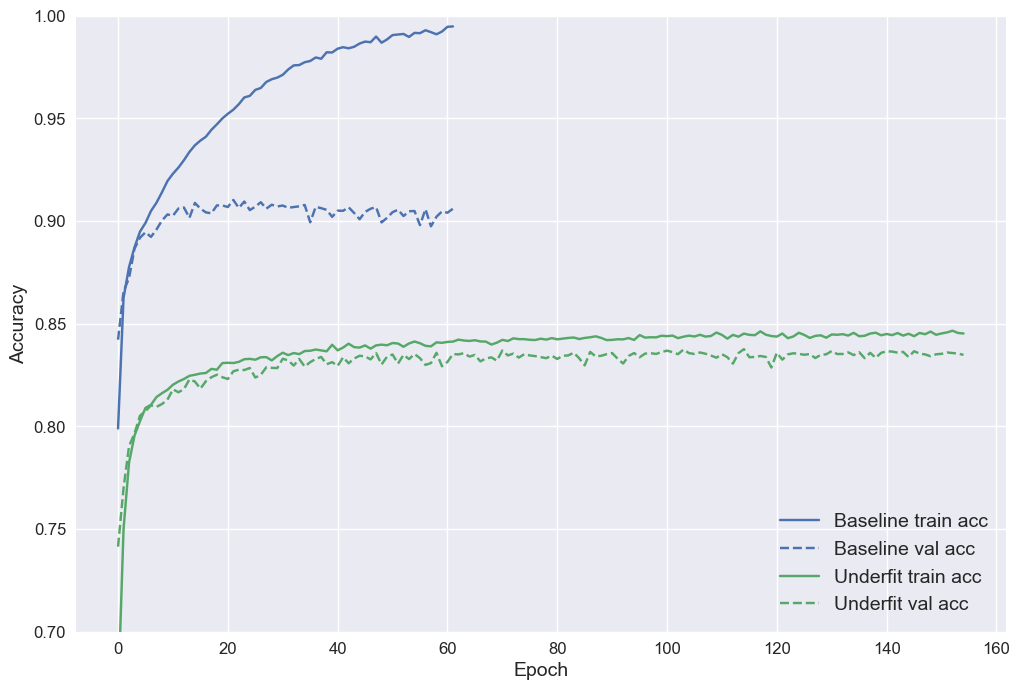

In [72]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(underfitted_hist_df['Underfit train acc'], color='C1', linestyle='-',label='Underfit train acc')
plt.plot(underfitted_hist_df['Underfit val acc'], color='C1', linestyle='--',label='Underfit val acc')

plt.ylim([0.7,1])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)

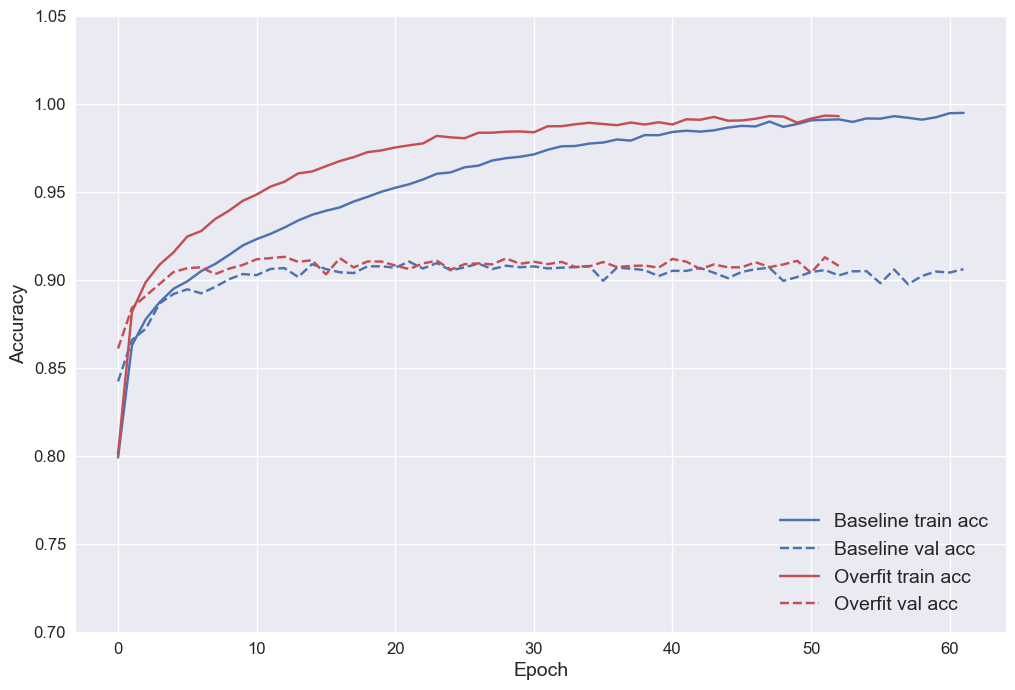

In [73]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(overfitted_hist_df['Overfit train acc'], color='C2', linestyle='-',label='Overfit train acc')
plt.plot(overfitted_hist_df['Overfit val acc'], color='C2', linestyle='--',label='Overfit val acc')

plt.ylim([0.7,1.05])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


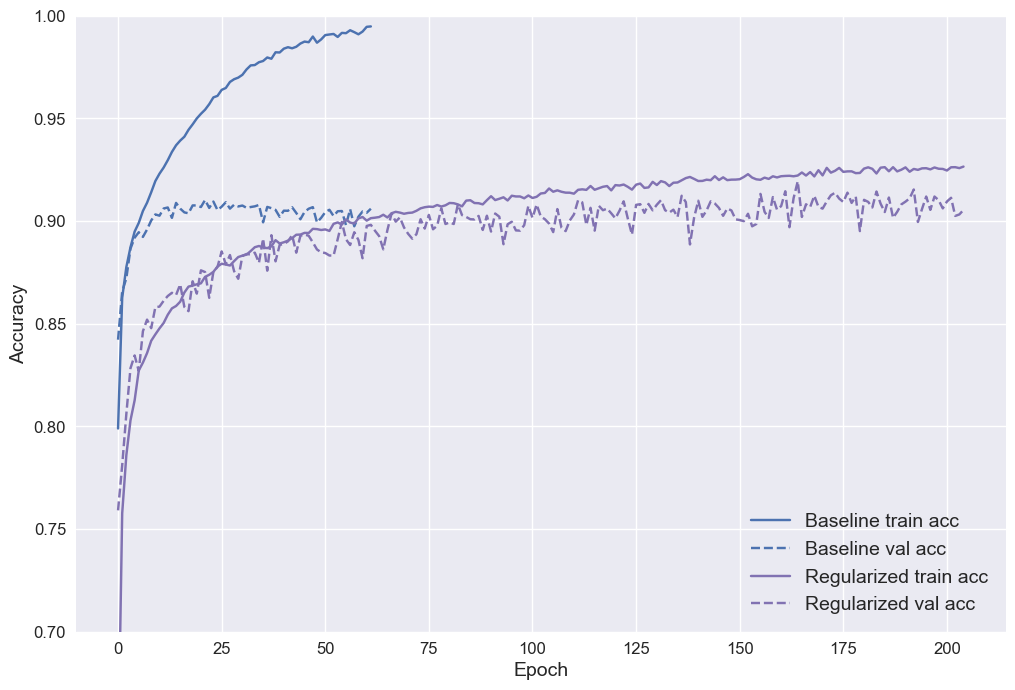

In [74]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')


plt.plot(regularized_hist_df['Regularized train acc'], color='C3', linestyle='-',label='Regularized train acc')
plt.plot(regularized_hist_df['Regularized val acc'], color='C3', linestyle='--',label='Regularized val acc')

plt.ylim([0.7,1.])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


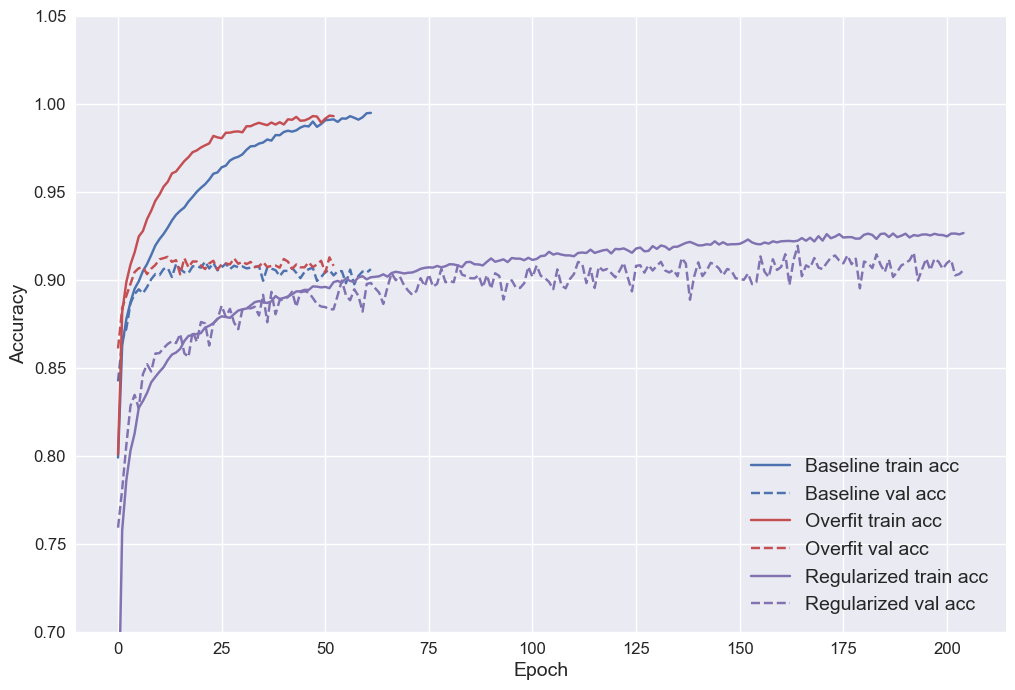

In [75]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(overfitted_hist_df['Overfit train acc'], color='C2', linestyle='-',label='Overfit train acc')
plt.plot(overfitted_hist_df['Overfit val acc'], color='C2', linestyle='--',label='Overfit val acc')

plt.plot(regularized_hist_df['Regularized train acc'], color='C3', linestyle='-',label='Regularized train acc')
plt.plot(regularized_hist_df['Regularized val acc'], color='C3', linestyle='--',label='Regularized val acc')

plt.ylim([0.7,1.05])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


# **Model evaluation on test set**

In [76]:
scores = baseline_model.evaluate(x_test.reshape([-1]+BASELINE_INPUT_SHAPE), test_one_hot, verbose=1)
names = baseline_model.metrics_names

for i in range(len(scores)):
  print(f'Baseline model test {names[i]}: {scores[i]:.4f}')

 24/313 [=>............................] - ETA: 1s - loss: 0.3291 - accuracy: 0.9049

2022-10-29 21:51:59.408800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 0.3208 - accuracy: 0.9012
Baseline model test loss: 0.3208
Baseline model test accuracy: 0.9012


In [77]:
scores = underfitted_model.evaluate(x_test.reshape([-1]+UNDERFIT_INPUT_SHAPE), test_one_hot, verbose=1)
names = underfitted_model.metrics_names

for i in range(len(scores)):
  print(f'Underfitted model test {names[i]}: {scores[i]:.4f}')

 22/313 [=>............................] - ETA: 2s - loss: 0.4731 - accuracy: 0.8395

2022-10-29 21:52:01.617505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 0.4970 - accuracy: 0.8268
Underfitted model test loss: 0.4970
Underfitted model test accuracy: 0.8268


In [78]:
scores = overfitted_model.evaluate(x_test.reshape([-1]+OVERFIT_INPUT_SHAPE), test_one_hot, verbose=1)
names = overfitted_model.metrics_names

for i in range(len(scores)):
  print(f'Overfitted model test {names[i]}: {scores[i]:.4f}')

 16/313 [>.............................] - ETA: 2s - loss: 0.3041 - accuracy: 0.9160

2022-10-29 21:52:03.846597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 0.3175 - accuracy: 0.9064
Overfitted model test loss: 0.3175
Overfitted model test accuracy: 0.9064


In [79]:
scores = regularized_model.evaluate(x_test.reshape([-1]+REGULARIZED_INPUT_SHAPE), test_one_hot, verbose=1)
names = regularized_model.metrics_names

for i in range(len(scores)):
  print(f'Regularized model test {names[i]}: {scores[i]:.4f}')

 10/313 [..............................] - ETA: 3s - loss: 0.5036 - accuracy: 0.9250

2022-10-29 21:52:06.278406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 10ms/step - loss: 0.4894 - accuracy: 0.9130
Regularized model test loss: 0.4894
Regularized model test accuracy: 0.9130


# Making predictions and plotting the result

 55/313 [====>.........................] - ETA: 0s

2022-10-29 21:53:50.894143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step


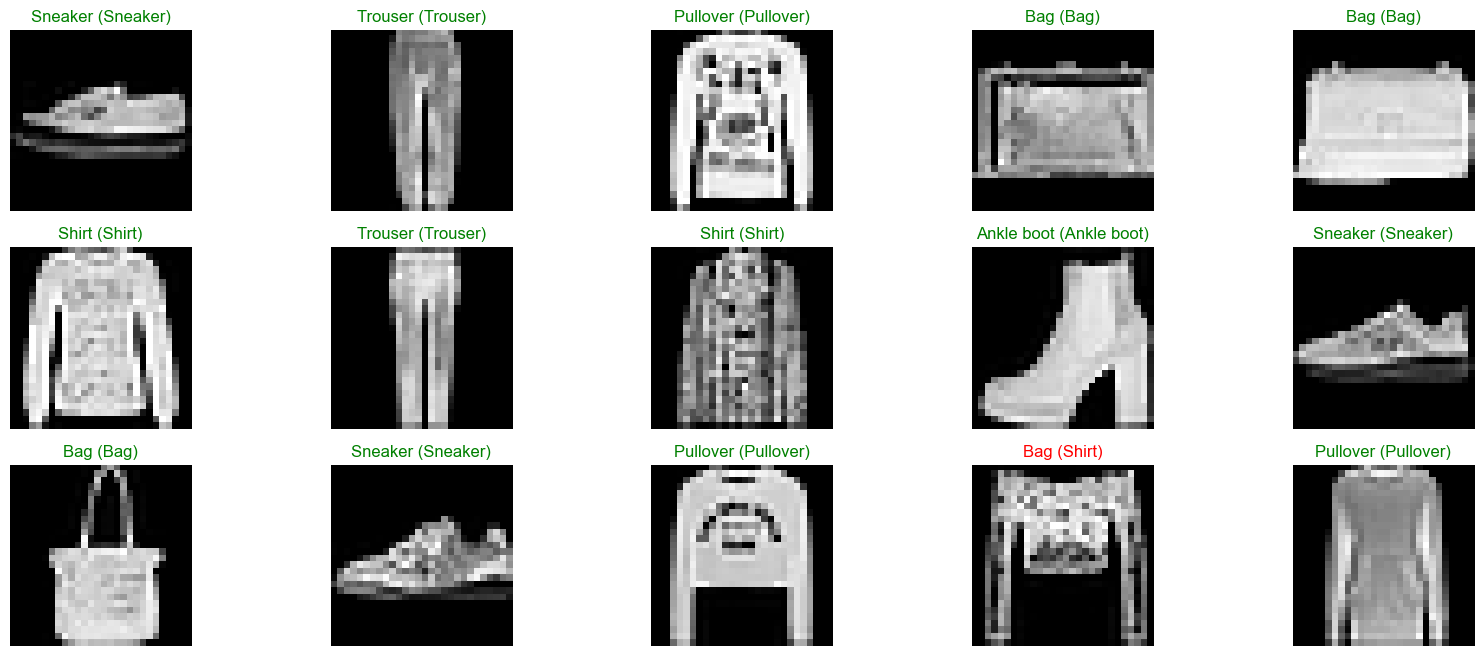

In [82]:
prediction = regularized_model.predict(x_test)


figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(x_test[index].reshape(28,28), cmap='gray')
    predict_index = np.argmax(prediction[index])
    true_index = np.argmax(test_one_hot[index])
   
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [80]:
#save models
regularized_model.save('Saved Models/m')

INFO:tensorflow:Assets written to: Saved Models/regularized9130/assets


INFO:tensorflow:Assets written to: Saved Models/regularized9130/assets


In [81]:
regularized_model.summary()

Model: "regularized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1088      
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        65600     
                                                 